# Deduplication

In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import sqlalchemy
from collections import Counter
import datetime
from __future__ import division
CONFIG_PATH = 'database.yml'
sns.set(color_codes=True)
%matplotlib inline
import collections
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
with open(CONFIG_PATH) as f:
    config = yaml.load(f)
engine = sqlalchemy.create_engine('postgres://', connect_args=config)

/Users/mbauman/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


192191/194130 (99.0011847731%) records matched


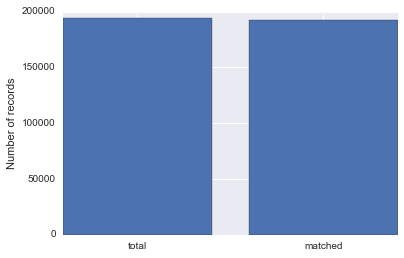

In [2]:
# Number of records/identities:
tot = engine.execute('SELECT count(*) from dedupe.entries').fetchone()[0]
uniq = engine.execute('SELECT count(*) from dedupe.entries_unique').fetchone()[0]
tot_matched = engine.execute('SELECT count(dedupe_id) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [tot,tot_matched],tick_label=['total','matched'],align='center');
plt.ylabel("Number of records");

print("{}/{} ({}%) records matched".format(tot_matched, tot, 100*tot_matched/tot))

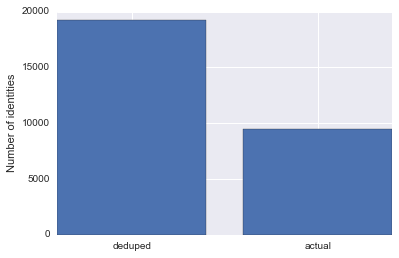

In [3]:
dedup = engine.execute('SELECT count(distinct dedupe_id) from dedupe.entries').fetchone()[0]
actual = engine.execute('SELECT count(distinct uuid) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [dedup,actual],tick_label=['deduped','actual'],align='center');
plt.ylabel("Number of identities");

# Falsely merged persons

In [4]:
df = pd.read_sql('SELECT dedupe_id, count(distinct uuid) from dedupe.entries where dedupe_id is not null group by dedupe_id', engine)
print("{} falsely merged identities; {}% of all identities".format(sum(df['count'] > 1), 100*sum(df['count'] > 1)/actual))

88 falsely merged identities; 0.924758301807% of all identities


In [9]:
dups = df[df['count'] > 1].dedupe_id
# Many are twins:
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[2]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Michael,Stafford,386-13-2767,M,1992-09-02,white,nonhispanic,93989,Michael Stafford,775
1,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Michael,Stafford,397-13-2767,M,1992-09-02,white,None,94003,Michael Stafford,775
2,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Mick,Stafford,396-13-2767,M,1992-09-02,white,nonhispanic,93994,Mick Stafford,775
3,1d725a7f-6e8b-47dd-b7e2-bae37f5bf046,David,Stafford,396-13-2768,M,1992-09-02,white,nonhispanic,193500,David Stafford,775
4,1d725a7f-6e8b-47dd-b7e2-bae37f5bf046,David,Stafford,396-13-2768,M,1992-09-02,white,nonhispanic,193502,David Stafford,775
5,1d725a7f-6e8b-47dd-b7e2-bae37f5bf046,David,Stafford,396-13-2768,M,1992-09-02,white,nonhispanic,193503,David Stafford,775
6,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Michael,Stafford,None,M,1992-09-02,white,nonhispanic,93991,Michael Stafford,775
7,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Michael,Stafford,396-13-2767,M,1992-09-02,white,None,94006,Michael Stafford,775
8,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Michael,Stafford,396-13-2767,M,1992-09-02,white,None,93981,Michael Stafford,775
9,bbd79f50-98f0-4c86-afe0-97f32b5909bb,Michael,Stafford,396-13-2767,M,1992-09-02,None,nonhispanic,94001,Michael Stafford,775


In [10]:
# Some are SSN collisions?
pd.read_sql("SELECT * FROM dedupe.entries WHERE ssn = '079-51-3754'", engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,e4e61f1c-07d8-4815-bf50-8adcb1e69b71,Deborah,Gonzalez,079-51-3754,F,1953-11-11,other,nonhispanic,160066,Deborah Gonzalez,983
1,e4e61f1c-07d8-4815-bf50-8adcb1e69b71,Deborah,Montgomery,079-51-3754,F,1953-12-17,white,nonhispanic,160042,Deborah Montgomery,983
2,b3ef1569-2e36-40d0-b917-174275efa430,Stephanie,Ray,079-51-3754,F,1953-11-20,white,None,188574,Stephanie Ray,8785
3,b3ef1569-2e36-40d0-b917-174275efa430,Stephanie,Ray,079-51-3754,F,1953-06-26,white,nonhispanic,188578,Stephanie Ray,8785
4,b3ef1569-2e36-40d0-b917-174275efa430,Stephanie,Ray,079-51-3754,F,None,None,nonhispanic,188575,Stephanie Ray,8785


In [15]:
# And some just very similar
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[4]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Lopez,019-11-7755,F,1988-06-26,asian,nonhispanic,23874,Jessica Lopez,1264
1,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Lopez,019-11-7755,F,1988-10-11,amindian,None,23895,Jessica Lopez,1264
2,380433e4-90ae-42d4-a667-6c7acb98ae99,Jessica,Bartlett,118-99-8370,F,1988-01-09,white,nonhispanic,100090,Jessica Bartlett,1264
3,380433e4-90ae-42d4-a667-6c7acb98ae99,Jessica,Callahan,118-99-8370,F,1988-10-11,white,nonhispanic,100102,Jessica Callahan,1264
4,380433e4-90ae-42d4-a667-6c7acb98ae99,Jessica,Bartlett,118-99-8370,F,1988-10-11,white,nonhispanic,100094,Jessica Bartlett,1264
5,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Doyle,019-11-7755,F,1988-10-11,asian,None,23863,Jessica Doyle,1264
6,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Lopez,019-10-7854,F,1988-10-11,asian,nonhispanic,23875,Jessica Lopez,1264
7,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Lopez,019-11-7755,F,1988-10-11,asian,nonhispanic,23871,Jessica Lopez,1264
8,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Lopez,019-11-7755,F,1988-10-11,other,nonhispanic,23891,Jessica Lopez,1264
9,cc22930f-8afa-40c3-b2e9-2fed1c725035,Jessica,Dixon,019-11-7755,F,1988-10-11,asian,nonhispanic,23870,Jessica Dixon,1264


# Split identities

In [16]:
# Number of persons that got split into two identities
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) from dedupe.entries group by uuid', engine)
sum(df['count'] > 1)

5151

In [12]:
splits = df[df['count'] > 1].uuid
# Some of these are very obvious, and should have been captured:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(splits.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,427-78-7157,F,1973-05-14,white,hispanic,103650,Rebecca Bryan,15318
1,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,427-78-7157,F,1973-07-28,white,nonhispanic,103657,Rebecca Bryan,15318
2,00180c25-35e6-4f9d-81dd-5c750d9fb017,Becky,Bryan,427-78-7157,F,1973-05-14,white,nonhispanic,103673,Becky Bryan,15318
3,00180c25-35e6-4f9d-81dd-5c750d9fb017,Reba,Bryan,427-78-8167,F,1973-05-14,white,nonhispanic,103665,Reba Bryan,15318
4,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,427-78-7157,F,1973-05-14,white,nonhispanic,103672,Rebecca Bryan,15318
5,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,None,F,1972-10-19,None,nonhispanic,103669,Rebecca Bryan,291
6,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,526-78-6157,F,1973-05-14,None,nonhispanic,103668,Rebecca Bryan,15318
7,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,427-78-7157,F,1973-05-14,white,nonhispanic,103659,Rebecca Bryan,15318
8,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,427-78-7157,F,1973-05-14,white,nonhispanic,103658,Rebecca Bryan,15318
9,00180c25-35e6-4f9d-81dd-5c750d9fb017,Rebecca,Bryan,427-78-7157,F,1973-05-14,None,None,103656,Rebecca Bryan,15318


# Ignored persons

In [10]:
# Number of persons that were ignored entirely
sum(df['count'] == 0)

6

In [11]:
ignores = df[df['count'] == 0].uuid
# These records simply had insufficient data and were excluded by rule:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(ignores.iloc[0]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,1472ca98-8eb1-48ac-b568-da2ca475fd3c,Marcia,Perry,None,F,None,amindian,nonhispanic,24093,Marcia Perry,None


# Incomplete persons

In [12]:
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) as identities, count(dedupe_id)*1.0/count(*) as completeness from dedupe.entries group by uuid', engine)
sum(df[(df.identities == 1)].completeness < 1)

417

In [13]:
incompletes = df[(df.identities == 1) & (df.completeness < 1)].uuid
# Like above, these persons just had some records with insufficient data that were excluded by rule
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(incompletes.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-02,None,nonhispanic,4623,Ashley Nicholson,7100.0
1,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,white,nonhispanic,4622,Ashley Nicholson,7100.0
2,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashleyy,Nicholson,None,F,1967-04-24,None,nonhispanic,4625,Ashleyy Nicholson,7100.0
3,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-22,white,nonhispanic,4616,Ashley Nicholson,7100.0
4,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,white,nonhispanic,4620,Ashley Nicholson,7100.0
5,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,007-47-4789,F,1967-04-24,white,nonhispanic,4624,Ashley Nicholson,7100.0
6,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,white,None,4627,Ashley Nicholson,7100.0
7,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,1967-04-24,amindian,None,4617,Ashley Nicholson,7100.0
8,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,006-47-4889,F,None,white,None,4626,Ashley Nicholson,7100.0
9,00dfbe6c-57d8-472a-8033-76cb9dd91c59,Ashley,Nicholson,None,F,None,white,None,4618,Ashley Nicholson,NaN
